# Финальный проект - Телекоммуникации

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.


**Описание услуг**

- Оператор предоставляет два основных типа услуг: 
    
    - Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
    - Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
    

- Также доступны такие услуги:

    - Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
    - Выделенная линия технической поддержки (TechSupport);
    - Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
    - Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

**Цель** : Получить модель машинного обучения, которая будет предсказывать отток клиентов. И на основе этих предсказаний, предпринимать какие-либо действия для удержания клиента.

*Используемые библиотеки:*

In [1]:
pip install matplotlib==3.8.0

     |████████████████████████████████| 11.6 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 50.8 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 74.0 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn==1.3.1

     |████████████████████████████████| 10.9 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 62.1 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install optuna

     |████████████████████████████████| 404 kB 1.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

import optuna

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, ConfusionMatrixDisplay


In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Изучение, подготовка данных

In [7]:
try:
    contract = pd.read_csv('contract_new.csv')
    personal = pd.read_csv('personal_new.csv')
    internet = pd.read_csv('internet_new.csv')
    phone = pd.read_csv('phone_new.csv')
except Exception:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')

Рассмотрим таблицу ***contract***:

In [8]:
contract.shape

(7043, 8)

In [9]:
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [10]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [11]:
contract.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

**Вывод** по таблице ***contract***:

- В таблице **7043** строки и **8** столбцов. Это значит всего 7043 клиента.

- Рассмотрели таблицу на наличие пропусков, пропусков нет. Приведем названия столбцов к одному виду:
`customerID` $\to$ `CustomerID`. 

- Поменям тип данных:
    - `BeginDate`: object $\to$ date;
    - `EndDate`: object $\to$ date;
    - `TotalCharges`: object $\to$ float.

- К `Type`, `PaperlessBilling`, `PaymentMethod` в дальнейшем надо будет применить **One Hot Encoder**.

- С помощью столбца `EndDate` надо выделить целевой признак. Если в `EndDate` No, тогда целевой признак равен **0**, если стоит дата целевой признак равен **1**.

Рассмотрим таблицу ***personal***:

In [12]:
personal.shape

(7043, 5)

In [13]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [14]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [15]:
personal.isnull().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

**Вывод** по таблице ***personal***:

- В таблице **7043** строки и **5** столбцов. Количесвто строк в данной таблице столько же сколько и в таблице **clients** значит представлена информация по всем клиентам.
- В таблице ***personal*** также нет пропусков. Для единообразия изменим названия некоторых столбцов: 
    - `сustomerID` $\to$ `CustomerID`;
    - `gender` $\to$ `Gender`.

- В дальнейшем для столбцов `Gender`, `SeniorCitizen`, `Partner` и `Dependents` понадобится **One Hot Encoder**.

In [16]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Рассмотрим таблицу ***internet***:

In [17]:
internet.shape

(5517, 8)

In [18]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [19]:
internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

**Вывод** по таблице ***internet***:

- В таблице **5517** строк и **8** столбцов. Строк меньше, чем в таблице **clients**, это значит, что информация не по всем клиентам.
- В таблице ***internet*** также нет пропусков. Для единообразия изменим названия некоторых столбцов: 
    - `сustomerID` $\to$ `CustomerID`.

- В дальнейшем для столбцов `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`,	`TechSupport`, `StreamingTV` и `StreamingMovies` понадобится **One Hot Encoder**.

Рассмотрим таблицу ***phone***:

In [20]:
phone.shape

(6361, 2)

In [21]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [22]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [23]:
phone.isnull().sum()

customerID       0
MultipleLines    0
dtype: int64

**Вывод** по таблице ***phone***:

- В таблице **6361** строк и **2** столбцов. Строк меньше, чем в таблице **clients**, это значит, что информация не по всем клиентам.
- В таблице ***phone*** также нет пропусков. Для единообразия изменим названия некоторых столбцов: 
    - `сustomerID` $\to$ `CustomerID`.

- В дальнейшем для столбца `MultipleLines` понадобится **One Hot Encoder**.

План 
--

1. Изучить данные, выполнить первичную обработку данных (изменить: названия столбцов, тип данных и т.д)
2. Выполнить исследовательский анализ, проверить данные на аномалии. Сделать визуализацию данных: построить графики, диаграммы и т.д.
3. Подготовить данные к моделированию: масштабирование, кодировка данных.
4. Построить модель машинного обучения, подобрать гиперпараметры. Проанализировать AUC-ROC моделей и выбрать лучшую модель.
5. Проверить модель на тестовой выборке и посчитать accuracy. Построить матрицу ошибок и оценить важность признаков.
6. Сделать выводы.


## Первичная обработка данных

В данном разделе:
- изменим названия столбцов;
- изменим типы данных;
- добавим новый  2 столбца в таблицу ***contract*** : `TotalDays`(всего дней сколько человек пользовался услугами), `Quit` (целеыой признак, ушел или нет).

* Изменим названия столбца `сustomerID` на `СustomerID` во всех таблицах (***contract***,***internet***, ***personal***, ***phone*** ). Также в таблице ***personal*** изменим `gender` на `Gender`.

In [24]:
contract.rename(columns={'customerID': 'CustomerID'}, inplace=True)

In [25]:
contract.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [26]:
internet.rename(columns={'customerID': 'CustomerID'}, inplace=True)

In [27]:
internet.head()

,CustomerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [28]:
personal.rename(columns={'customerID': 'CustomerID'}, inplace=True)
personal.rename(columns={'gender': 'Gender'}, inplace=True)

In [29]:
personal.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [30]:
phone.rename(columns={'customerID': 'CustomerID'}, inplace=True)

In [31]:
phone.head()

,CustomerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


* добавим целевой признак `Quit`;
  - если в ***EndDate*** 'No'значит человек не ушел и в `Quit` будет 0,
  - если в ***EndDate*** число значит человек ушел и в `Quit` будет 1.

In [32]:
contract['Quit'] = contract['EndDate'] != 'No'

In [33]:
contract.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,False
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,False
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,False
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,False
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,False


In [34]:
contract['Quit']  = contract['Quit'].astype(int)

In [35]:
contract.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0


 * в таблице ***contract*** изменим тип данных в некоторых столбцах:
    -  `BeginDate`: object $\to$ date;
    - `EndDate`: object $\to$ date;
    - `TotalCharges`: object $\to$ float.


In [36]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'] , format='%Y-%m-%d')

Для того, что перевести `EndDate` в datetime вместо 'No', поставим дату выгрузки данных: 2020-02-01.

In [37]:
contract['EndDate'] = contract['EndDate'].replace(['No'],' 2020-02-01')

In [38]:
contract.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0


In [39]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'] , format='%Y-%m-%d')

In [40]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'],errors='coerce')

In [41]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Quit              7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


* создадим столбец `TotalDays`(всего дней сколько человек пользовался услугами)

In [42]:
contract['TotalDays'] = contract['EndDate'] - contract['BeginDate']

In [43]:
contract.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit,TotalDays
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31 days
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036 days
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123 days
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371 days
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153 days


In [44]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   CustomerID        7043 non-null   object         
 1   BeginDate         7043 non-null   datetime64[ns] 
 2   EndDate           7043 non-null   datetime64[ns] 
 3   Type              7043 non-null   object         
 4   PaperlessBilling  7043 non-null   object         
 5   PaymentMethod     7043 non-null   object         
 6   MonthlyCharges    7043 non-null   float64        
 7   TotalCharges      7032 non-null   float64        
 8   Quit              7043 non-null   int64          
 9   TotalDays         7043 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(4), timedelta64[ns](1)
memory usage: 550.4+ KB


In [45]:
contract['TotalDays'] = contract['TotalDays'].dt.days

In [46]:
contract.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit,TotalDays
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


In [47]:
contract.isnull().sum()

CustomerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Quit                 0
TotalDays            0
dtype: int64

**Вывод**:
В данном разделе
- превели названия столбцов к одному виду;
- изменили типы данных в таблице ***contract***;
- добавили 2 новых столбца в таблицу ***contract*** : `TotalDays`(всего дней сколько человек пользовался услугами), `Quit` (целевой признак, ушел или нет).

## Исследовательский анализ

In [48]:
data = contract \
    .merge(personal, how='left', on='CustomerID') \
    .merge(internet, how='left', on='CustomerID') \
    .merge(phone, how='left', on='CustomerID') 

In [49]:
data.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit,TotalDays,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Рассмотрим пропуски в полученной таблице.

In [50]:
data.isnull().sum()

CustomerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
Quit                   0
TotalDays              0
Gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

- Пропуски в столбце `TotalCharges`

In [51]:
data[data['TotalCharges'].isnull()]

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit,TotalDays,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Можно заметить, что пропуски в столбце `TotalCharges`, у тех кто был подключен в день выгрузки данных, поэтому заменим Nan на 0.

In [52]:
data['TotalCharges'] = data['TotalCharges'].fillna(0)

In [53]:
data[data['TotalCharges'].isnull()]['TotalCharges'].count()

0

- будем считать, что пропуски  в столбцах `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines` возникли потому что клиент не пользуется этими услугами, и поставим вместо пропусков NotUsed.
               

In [54]:
for column in ('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'):
    data[column] = data[column].fillna('NotUsed')

### Портрет клиента

Составить портрет клиента в разрезе целевого признака в виде сводной таблицы, посчитать по призакам центральной тенденции (непрерывные - средние, категориальные/дискретные - мода), по средним расчитать относительную разницу, сделать вывод о среднем портрете уходящего и неуходящего клиента.

In [55]:
numerical = [ 'MonthlyCharges', 'TotalCharges','TotalDays']
categ =  ['BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod','Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [56]:
df_num = pd.DataFrame(round(data[data['Quit']==1][numerical].mean(),2),
                  columns=['mean/moda (отток)'], index = numerical)

In [57]:
df_num['mean/moda (не отток)'] = round(data[data['Quit']==0][numerical].mean(),2)

In [58]:
df_num['Mean(отток)/Mean(не отток)'] = (df_num['mean/moda (отток)']/df_num['mean/moda (не отток)'])

In [59]:
df_num['mean/moda (отток)'] = df_num['mean/moda (отток)'].astype('str')
df_num['mean/moda (не отток)'] = df_num['mean/moda (не отток)'].astype('str')
df_num['Mean(отток)/Mean(не отток)'] = df_num['Mean(отток)/Mean(не отток)'].astype('str')

In [60]:
df_num

,mean/moda (отток),mean/moda (не отток),Mean(отток)/Mean(не отток)
MonthlyCharges,75.55,62.76,1.2037922243467176
TotalCharges,2371.38,2067.87,1.146774216947874
TotalDays,924.86,893.68,1.0348894458866709


In [61]:
df_cat = pd.DataFrame(columns=['mean/moda (отток)'], index = categ)

In [62]:
for cat in categ:
    df_cat.loc[df_cat.index == cat,'mean/moda (отток)' ] = data[data['Quit'] == 1][cat].mode()[0]
    df_cat.loc[df_cat.index == cat, 'mean/moda (не отток)'] = data[data['Quit'] == 0][cat].mode()[0]
    df_cat.loc[df_cat.index == cat, 'Mean(отток)/Mean(не отток)'] = '-'

In [63]:
df_cat

,mean/moda (отток),mean/moda (не отток),Mean(отток)/Mean(не отток)
BeginDate,2014-02-01 00:00:00,2014-02-01 00:00:00,-
EndDate,2020-01-01 00:00:00,2020-02-01 00:00:00,-
Type,Month-to-month,Month-to-month,-
PaperlessBilling,Yes,Yes,-
PaymentMethod,Electronic check,Electronic check,-
Gender,Male,Male,-
SeniorCitizen,0,0,-
Partner,Yes,No,-
Dependents,No,No,-
InternetService,Fiber optic,Fiber optic,-


In [64]:
df = pd.concat([df_num, df_cat], axis=0)

In [65]:
df

,mean/moda (отток),mean/moda (не отток),Mean(отток)/Mean(не отток)
MonthlyCharges,75.55,62.76,1.2037922243467176
TotalCharges,2371.38,2067.87,1.146774216947874
TotalDays,924.86,893.68,1.0348894458866709
BeginDate,2014-02-01 00:00:00,2014-02-01 00:00:00,-
EndDate,2020-01-01 00:00:00,2020-02-01 00:00:00,-
Type,Month-to-month,Month-to-month,-
PaperlessBilling,Yes,Yes,-
PaymentMethod,Electronic check,Electronic check,-
Gender,Male,Male,-
SeniorCitizen,0,0,-


По полученно таблице можно сделать следующий вывод:
 - Клиенты, которые ушли:
     - ежемесечно платили больше, чем те, кто остался, соответсвенно и всего они заплатили больше;
     - в среднем дольше являлись клиентами данной компании;
     -  больше пользовались дополнительными услугами.
 - Клиенты, которые остались:
     - ежемесечно платят меньше;
     - в среднем они почти не пользуются дополнительными услугами.

Можно предположить, что в данной компании проблемы с дополнительными услугами.

### Количественные признаки

In [66]:
data.columns

Index(['CustomerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Quit', 'TotalDays',
       'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

Посторим гистограмму по всем числовым столбцам таблицы по всем клиентам. 

In [67]:
num_col = ['BeginDate', 'EndDate','MonthlyCharges', 'TotalCharges','TotalDays' ]

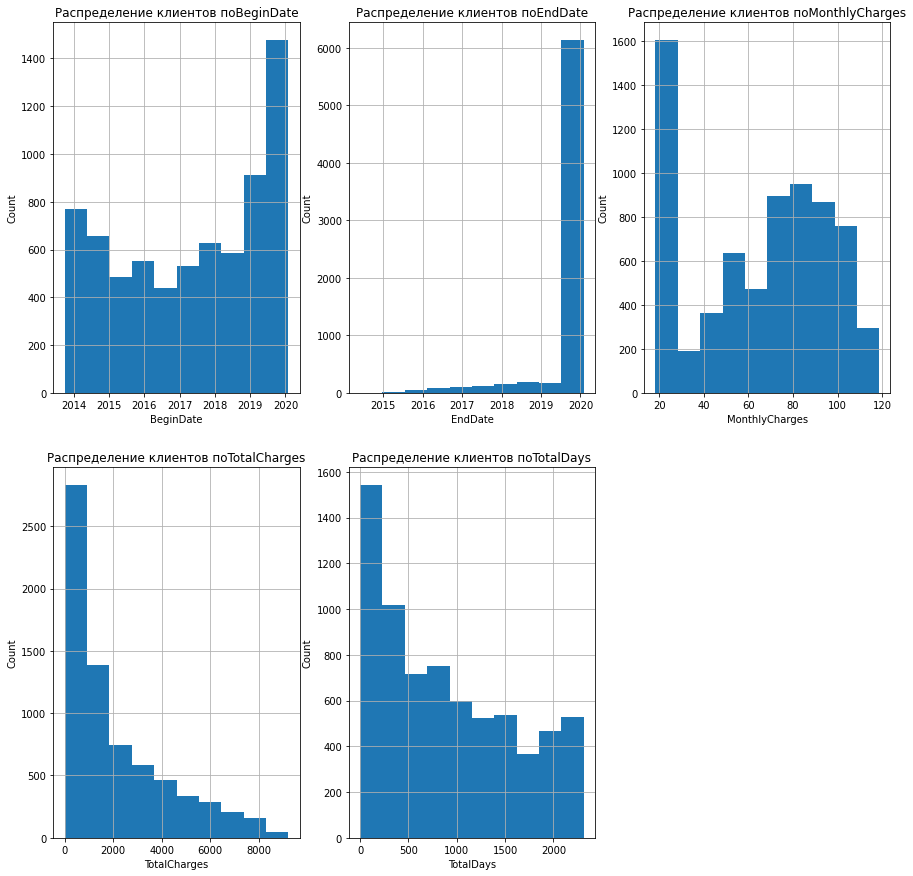

In [68]:

plt.figure(figsize=(15, 15))
i = 1
for col in num_col:
    plt.subplot(2, 3, i)
    data[col].hist()
    i += 1
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title('Распределение клиентов по'+ str(col))


    

По гистограмме можно сделать следующий вывод:
 - самый большой прирост клиентов приходится на 2019-2020 г.
 - в столбце `EndDate` так много клиентов покинуло в 2020 г., потому что мы все No заменили на дату выгрузки файлов.
 - дешевые тарифы у людей популярнее.

In [69]:
num_col = ['MonthlyCharges', 'TotalCharges','TotalDays' ]

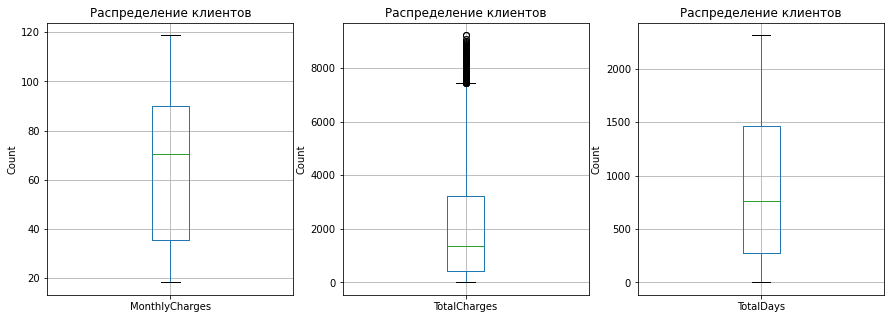

In [70]:
plt.figure(figsize=(15, 5))
i = 1
for col in num_col:
    plt.subplot(1, 3, i)
    data.boxplot(col);
    i += 1
    plt.ylabel('Count')
    plt.title('Распределение клиентов')


In [71]:
data[['MonthlyCharges', 'TotalCharges','TotalDays' ]].describe()

,MonthlyCharges,TotalCharges,TotalDays
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,898.555729
std,30.090047,2112.742814,683.130510
min,18.250000,0.000000,0.000000
25%,35.500000,436.750000,276.000000
50%,70.350000,1343.350000,761.000000
75%,89.850000,3236.690000,1461.000000
max,118.750000,9221.380000,2314.000000


In [72]:
data[['MonthlyCharges', 'TotalCharges','TotalDays' ]].corr()

,MonthlyCharges,TotalCharges,TotalDays
MonthlyCharges,1.000000,0.630440,0.220054
TotalCharges,0.630440,1.000000,0.821746
TotalDays,0.220054,0.821746,1.000000


По таблице корреляции видно, что корреляция между `TotalCharges` и `TotalDays` больше 0.8, оно и понятно, чем больше дней пользуется услугами, тем больше денег он заплатил. Удалим столбец `TotalCharges`.

In [73]:
del data['TotalCharges']

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   Quit              7043 non-null   int64         
 8   TotalDays         7043 non-null   int64         
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

Посмотрим на рспределение данных у клиентов, которые больше не пользуются услугами компании.

In [75]:
num_col = ['BeginDate', 'EndDate','MonthlyCharges','TotalDays' ]

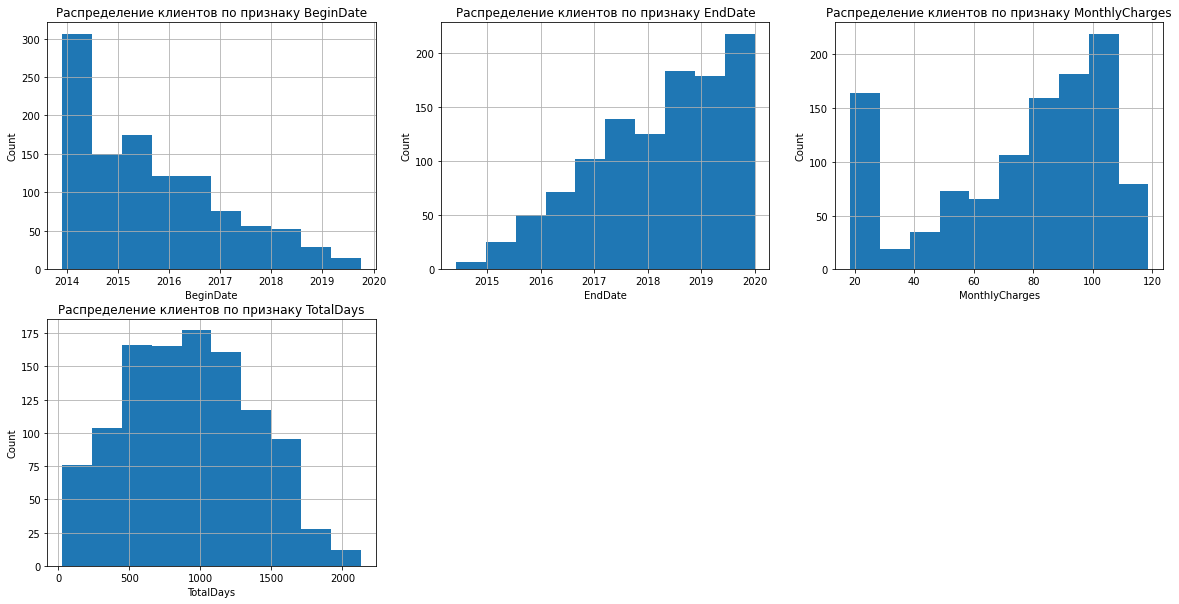

In [76]:
plt.figure(figsize=(20, 10))
i = 1
for col in num_col:
    plt.subplot(2, 3, i)
    data[data['Quit'] == 1][col].hist()
    i += 1
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title('Распределение клиентов по признаку '+ str(col))


In [77]:
data[data['Quit'] == 1][['MonthlyCharges','TotalDays' ]].describe()

,MonthlyCharges,TotalDays
count,1101.000000,1101.000000
mean,75.546004,924.863760
std,29.116213,458.771309
min,18.400000,28.000000
25%,56.150000,577.000000
50%,84.200000,915.000000
75%,99.500000,1249.000000
max,118.750000,2129.000000


In [78]:
data[data['Quit'] == 0][['MonthlyCharges','TotalDays' ]].describe()

,MonthlyCharges,TotalDays
count,5942.000000,5942.000000
mean,62.763455,893.681084
std,29.844462,716.958551
min,18.250000,0.000000
25%,30.062500,245.000000
50%,69.200000,702.000000
75%,87.237500,1523.000000
max,118.600000,2314.000000


Можно заметить, что люди которые отказались от услуг в среднем платили за них больше, чем те, кто не отказался.

### Категориальные признаки

In [79]:
cat_col = ['Type', 'Gender','PaperlessBilling', 'OnlineSecurity', 
           'InternetService', 'SeniorCitizen','Partner','Dependents',
           'MultipleLines','OnlineBackup','DeviceProtection','TechSupport',
          'StreamingTV','StreamingMovies', 'PaymentMethod']

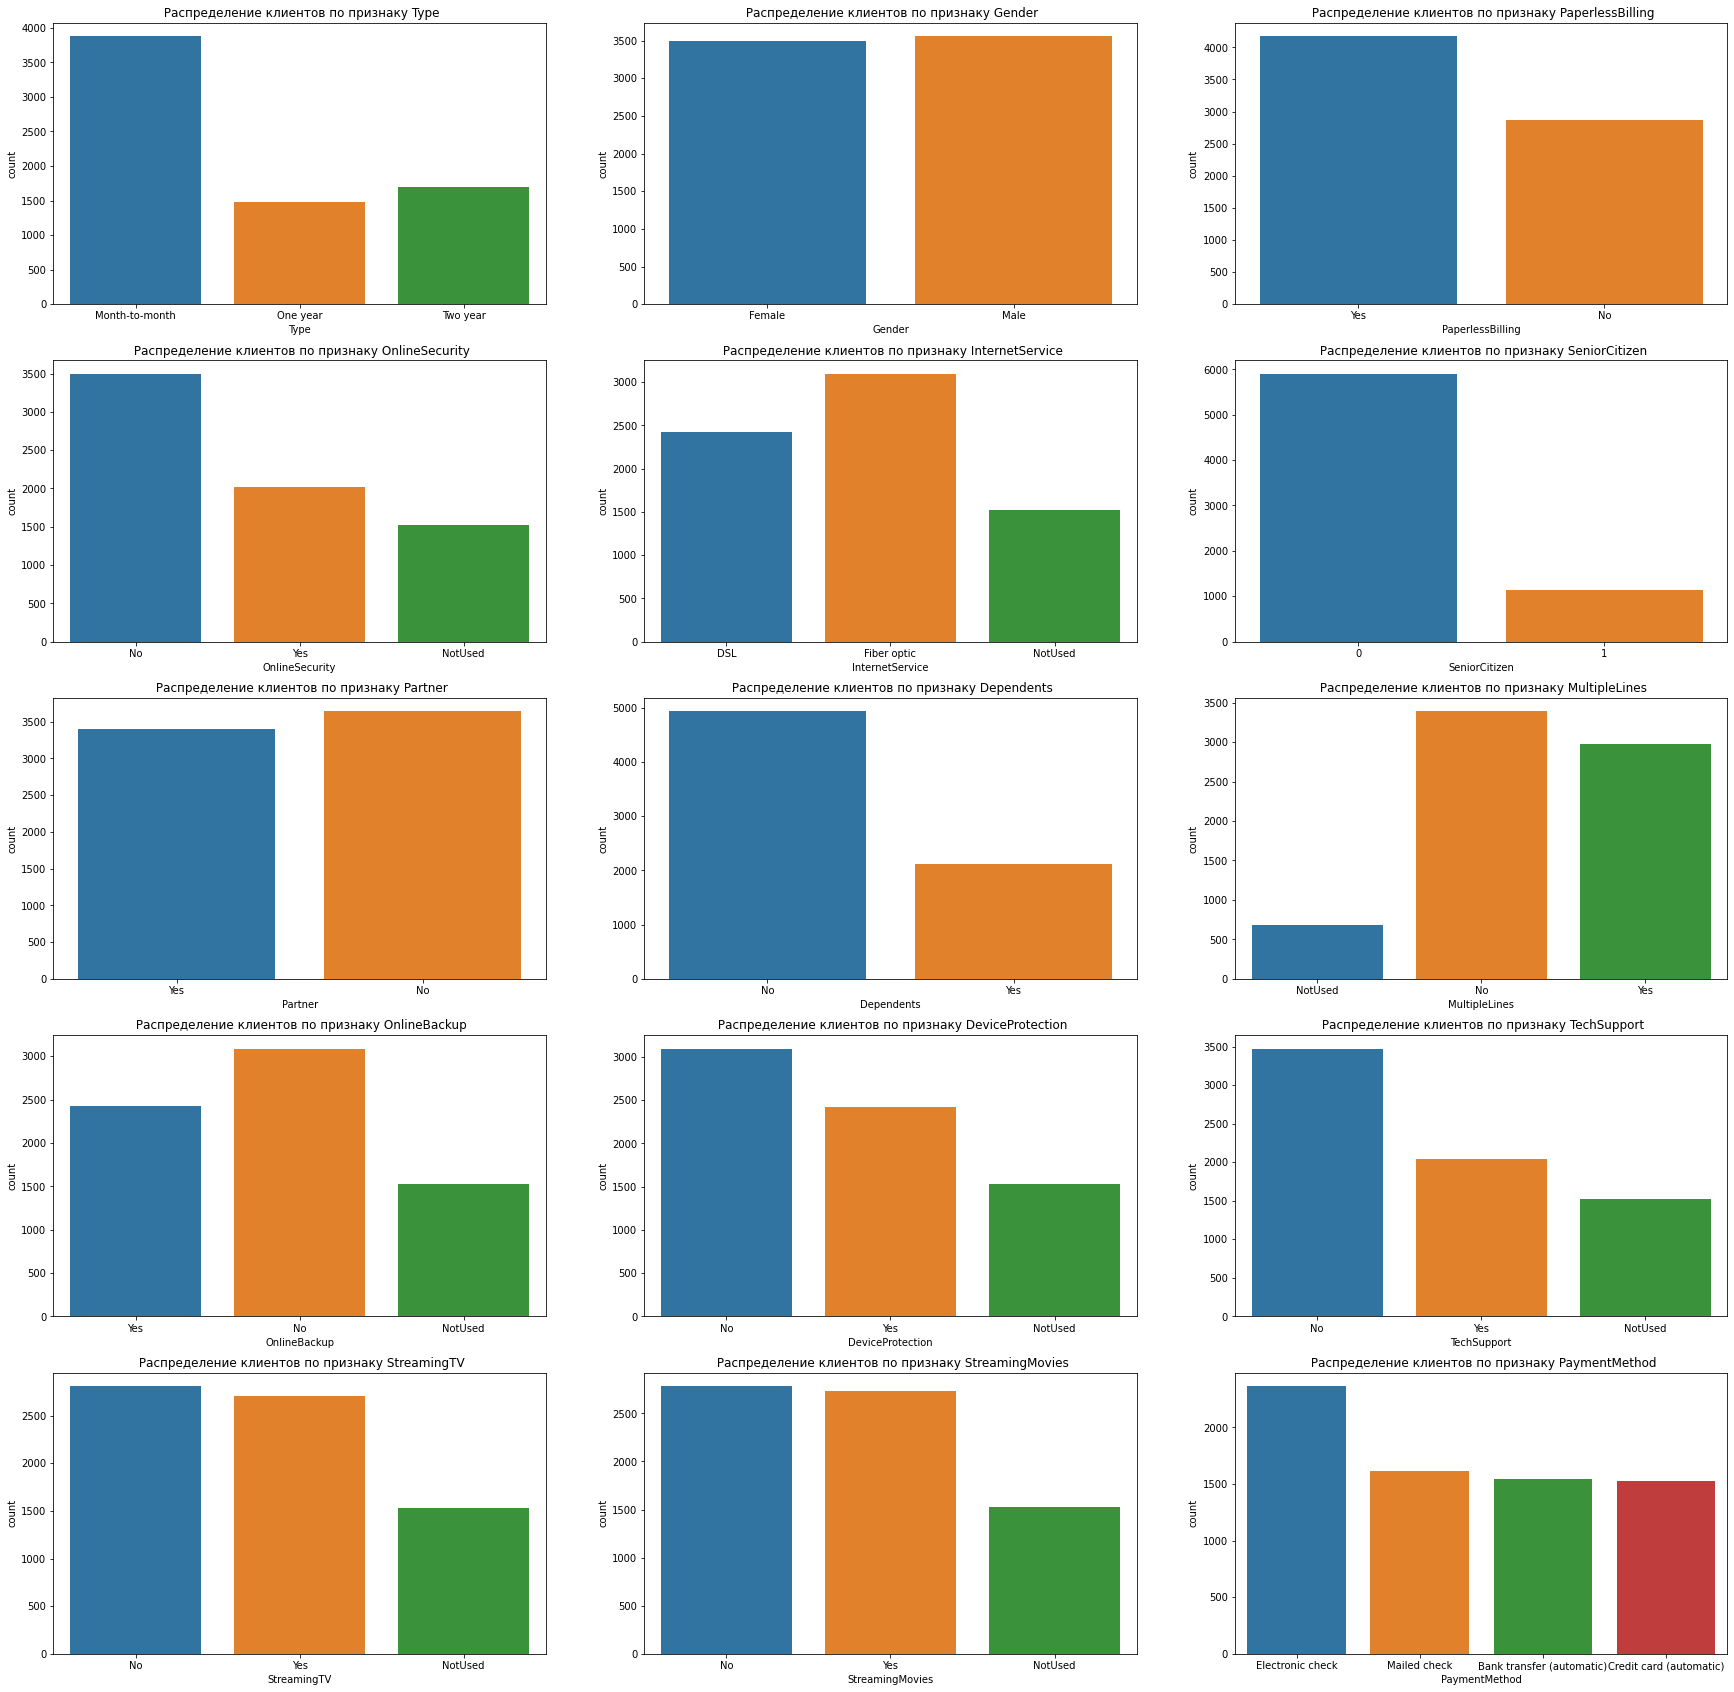

In [80]:
plt.figure(figsize=(30, 30))
i = 1
for col in cat_col:
    plt.subplot(5, 3, i)
    sns.countplot(x=col, data=data);
    plt.xlabel(col, loc='center')
    plt.title(' Распределение клиентов по признаку '+ str(col))

    i += 1
    

Вывод по категориальным данным:
- самый популярный вид тарифа - помесячный;
- больше людей пользуются электронным платежным документом;
- мало кто пользуется дополнительными услугами;
- людей пенсионного возраста меньше, чем не пенсионного.

Рассмотрим категориальные признаки для тех, кто отказался от услуг.

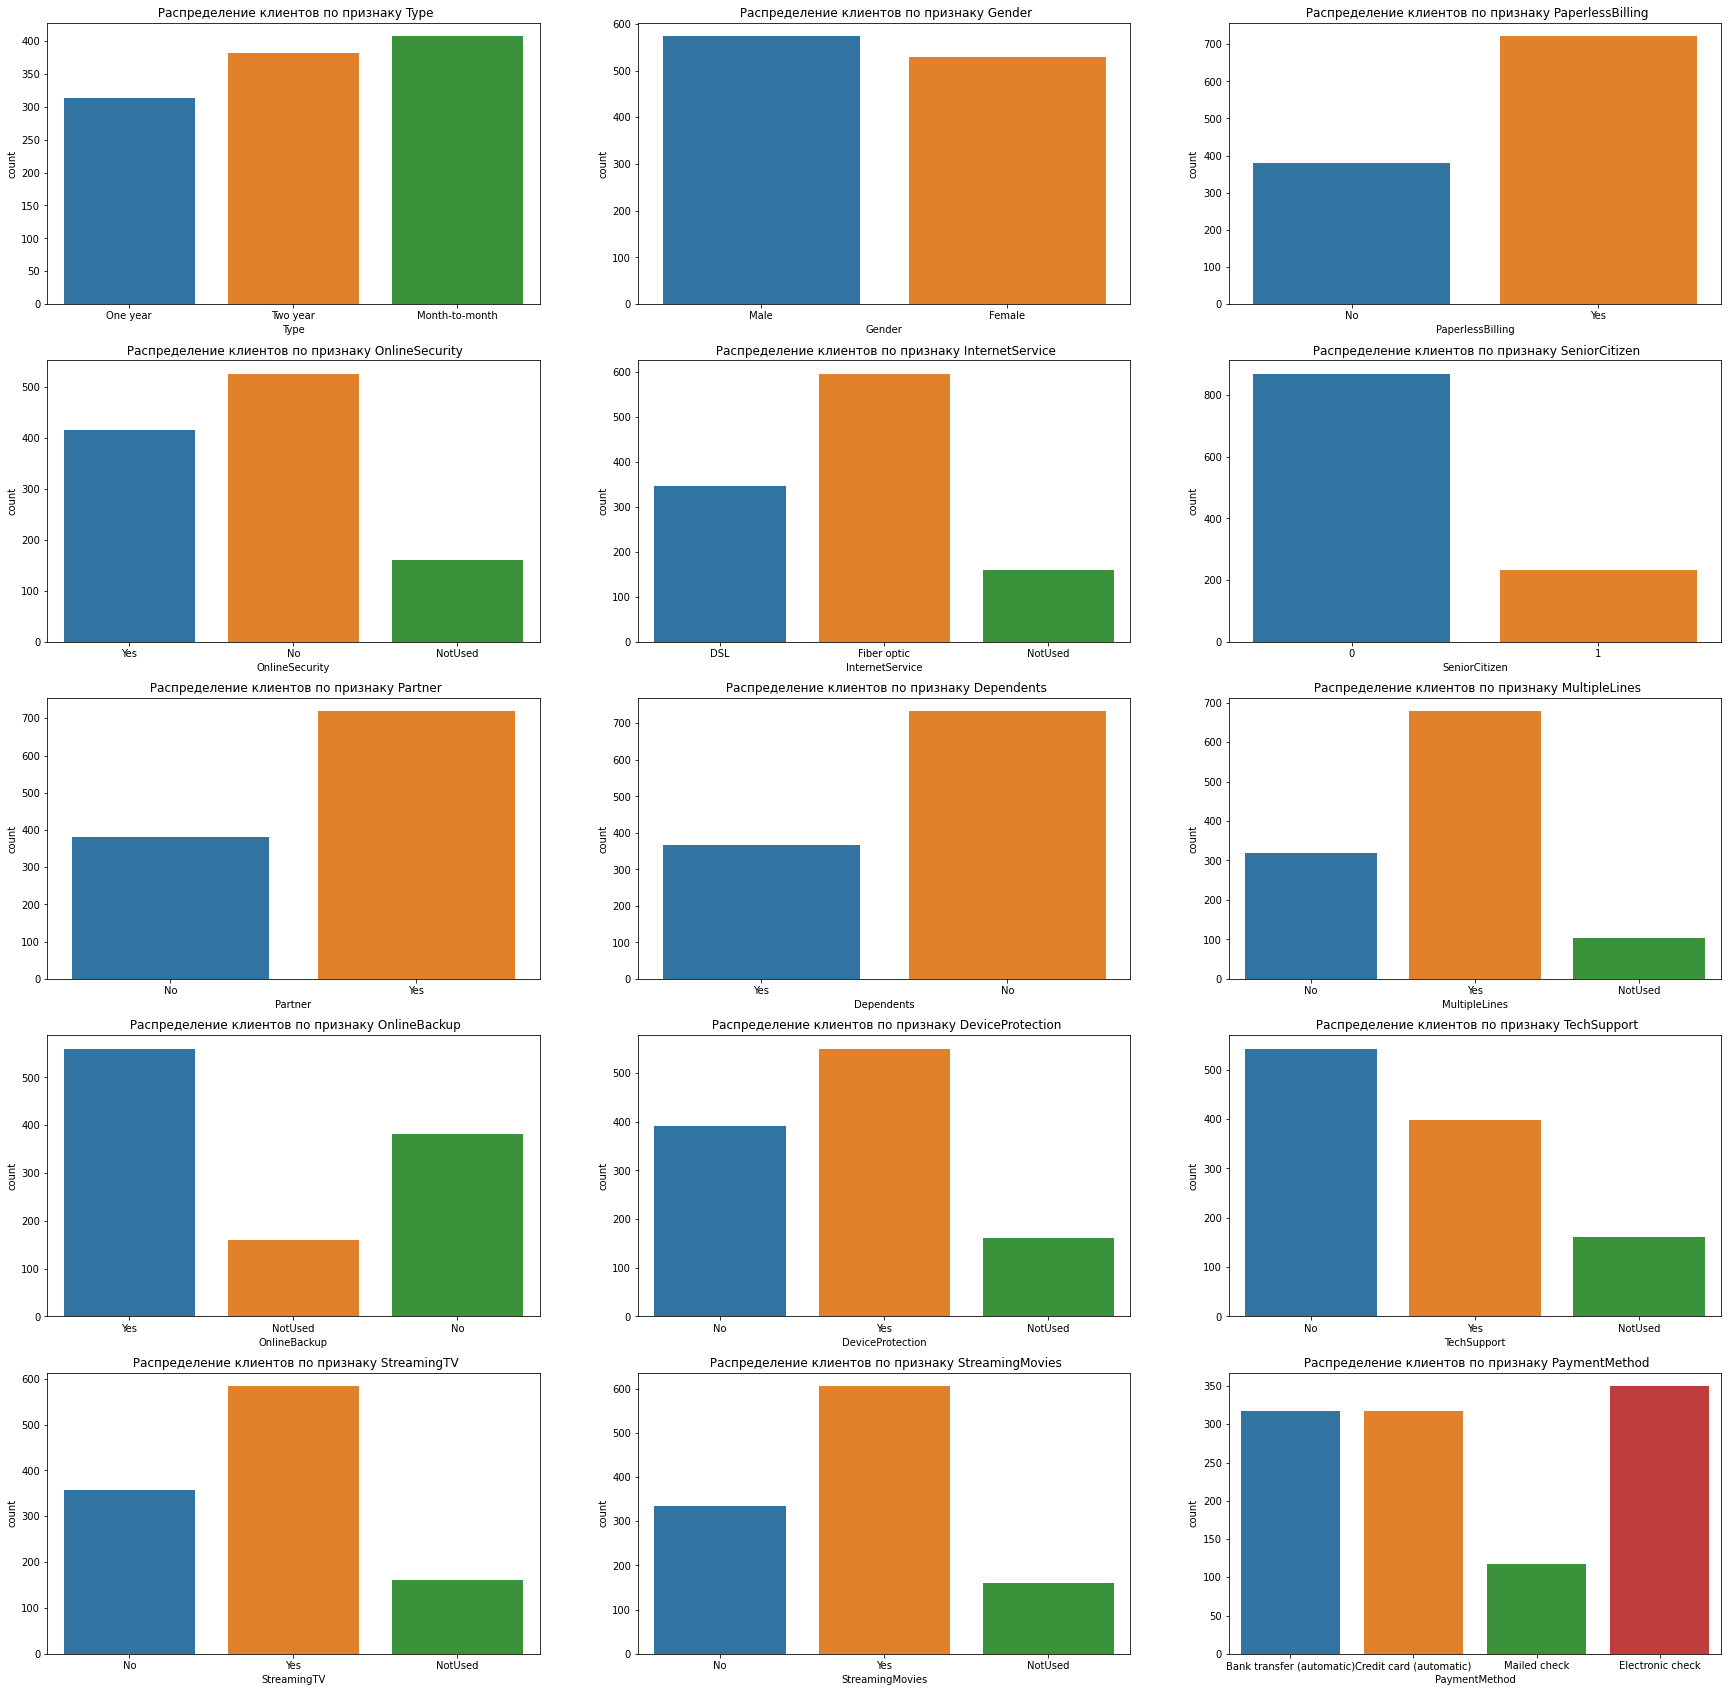

In [81]:
plt.figure(figsize=(30, 30))
i = 1
for col in cat_col:
    plt.subplot(5, 3, i)
    sns.countplot(x=col, data=data[data['Quit'] == 1]);
    plt.xlabel(col, loc='center')
    plt.title(' Распределение клиентов по признаку '+ str(col))
    i += 1

По тем, кто отказался от услуг можно заметить, что :
- они пользовались наличием возможности ведения параллельных линий во время звонка (`MultipleLines`);
- они пользовались услугами облачного хранилища файлов для резервного копирования данных (`OnlineBackup`);
- они пользовались антивирусом (`DeviceProtection`);
- они пользовались стриминговое телевидение (`StreamingTV`) и каталогом фильмов (`StreamingMovies`).

Возможно дополнительные возможности для клиентов были в приоретете, и они ушли поскольку эти возможности не оправдали ожидания.

Из данных можно удалить столбцы: `CustomerID`,`BeginDate`,`EndDate` они не будут влиять на обучение.

In [82]:
data = data.drop(['CustomerID', 'BeginDate', 'EndDate' ], axis = 1)

Рассмотрим категориальные данные на мультиколлинеарность:

In [83]:
interval_columns = ['MonthlyCharges','TotalDays']

/opt/conda/lib/python3.9/site-packages/seaborn/matrix.py:252: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


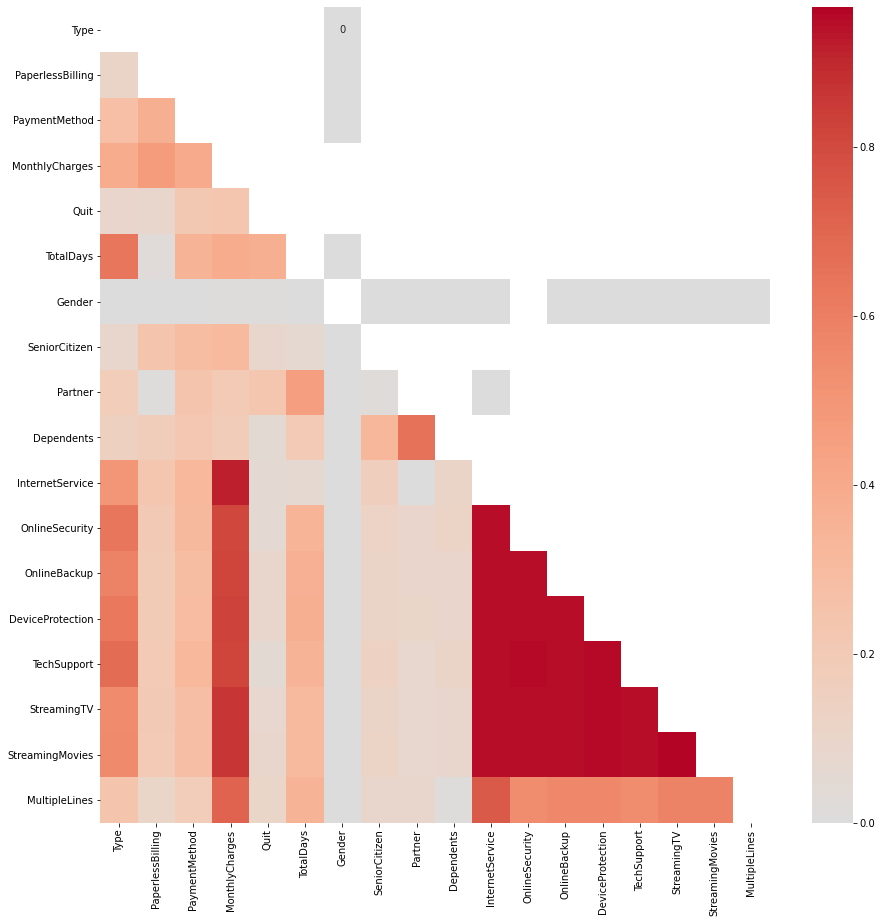

In [84]:
corr = data.phik_matrix(interval_cols = interval_columns)
matrix = np.triu(corr)
plt.figure(figsize = (15,15))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True, mask=matrix);

При пороговом значении корреляции 0.8, следует удалить столбцы `InternetService`, `OnlineSecurity`, `OnlineBackup`,`DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`(коррелируют с признаком monthly_charges).

Значение корреляции столбца `Gender` с другими столбцами равна нулю, поэтому удалим его.


In [85]:
data = data.drop(['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                  'TechSupport', 'StreamingTV', 'StreamingMovies', 'Gender' ], axis = 1)

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   Quit              7043 non-null   int64  
 5   TotalDays         7043 non-null   int64  
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   MultipleLines     7043 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 863.3+ KB


Проверим целевой признак на дисбаланс:`

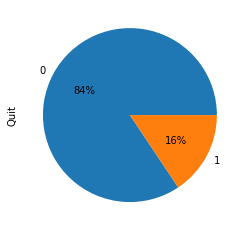

In [87]:
data['Quit'].value_counts().plot(kind='pie', autopct='%1.0f%%');

В наших данных есть дисбаланс классов.

**Вывод по разделу:**
 - самый большой прирост клиентов приходится на 2019-2020 г.
 - дешевые тарифы у людей популярнее.
 - люди которые отказались от услуг в среднем платили за них больше, чем те, кто не отказался;
 - самый популярный вид тарифа - помесячный;
 - больше людей пользуются электронным платежным документом;
 - мало кто пользуется дополнительными услугами;
 - людей пенсионного возраста меньше, чем не пенсионного;
 - люди, которые отказались от услуг много пользовались дополнительными услугами.

**Вывод по датафрейму**:

- устранены пропуски и аномалии;
- в результате проверки данных на мультиколениарность, были удалены лишние столбцы;
- был выявлен дисбаланс классов.

## Подготовка данных для моделирования

In [88]:
RANDOM_STATE = 110923

In [89]:
features = data.drop(['Quit'], axis=1)
target = data['Quit']

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=RANDOM_STATE)

In [90]:
features_train['SeniorCitizen'] = features_train['SeniorCitizen'].astype('object')

In [91]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 2610 to 4690
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5282 non-null   object 
 1   PaperlessBilling  5282 non-null   object 
 2   PaymentMethod     5282 non-null   object 
 3   MonthlyCharges    5282 non-null   float64
 4   TotalDays         5282 non-null   int64  
 5   SeniorCitizen     5282 non-null   object 
 6   Partner           5282 non-null   object 
 7   Dependents        5282 non-null   object 
 8   MultipleLines     5282 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 412.7+ KB


## Обучение моделей

Обучим 3 модели: 
- **LogisticRegression;** 
- **RandomForestClassifier;** 
- **CatBoostClassifier.**

Для обучения построим пайплайн.

Для кодирования и масштабирования будем использовать: StandartScaler, OneHotEncoder/OrdinalEncoder.

In [92]:
categories = ['SeniorCitizen','Type','PaperlessBilling','PaymentMethod','Partner', 'Dependents', 'MultipleLines']
numerical = ['MonthlyCharges', 'TotalDays']

Для модели Логической регрессии будем использовать OneHotEncoder.

In [93]:
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical), 
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categories)  
    ])

In [94]:
def objective(trial):    
    param_grid = {
                'solver': trial.suggest_categorical('solver',['liblinear']),
                'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
                'C': trial.suggest_float('C', 0,10)
    }
    model_lr = LogisticRegression(**param_grid, verbose=False, random_state=RANDOM_STATE)

    lr_pipeline = Pipeline(steps=[
            ('col_trans', preprocessor_lr),
            ('model', model_lr)
        ])
    accuracy = cross_val_score(lr_pipeline, features_train, target_train, cv=3, scoring = 'roc_auc').mean()
    return accuracy

study_lr = optuna.create_study(direction="maximize", study_name = 'log_reg_1')
study_lr.optimize(objective, n_trials=20)
print(study_lr.best_trial)
print()
print(f' AUC-ROC: {study_lr.best_value}')

[I 2023-09-22 16:07:39,093] A new study created in memory with name: log_reg_1
[I 2023-09-22 16:07:39,572] Trial 0 finished with value: 0.744593687987889 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.6430050707150112}. Best is trial 0 with value: 0.744593687987889.
[I 2023-09-22 16:07:40,177] Trial 1 finished with value: 0.7445854601574092 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 9.860749333274194}. Best is trial 0 with value: 0.744593687987889.
[I 2023-09-22 16:07:40,769] Trial 2 finished with value: 0.7445687117741584 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 9.730626326367638}. Best is trial 0 with value: 0.744593687987889.
[I 2023-09-22 16:07:41,384] Trial 3 finished with value: 0.7446208957619639 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.1462003549782962}. Best is trial 3 with value: 0.7446208957619639.
[I 2023-09-22 16:07:41,973] Trial 4 finished with value: 0.7445632752299609 and parameters: {'solve

FrozenTrial(number=17, state=TrialState.COMPLETE, values=[0.7446249854152883], datetime_start=datetime.datetime(2023, 9, 22, 16, 7, 49, 246309), datetime_complete=datetime.datetime(2023, 9, 22, 16, 7, 49, 784268), params={'solver': 'liblinear', 'penalty': 'l1', 'C': 1.2481150439048627}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'solver': CategoricalDistribution(choices=('liblinear',)), 'penalty': CategoricalDistribution(choices=('l1', 'l2')), 'C': FloatDistribution(high=10.0, log=False, low=0.0, step=None)}, trial_id=17, value=None)

 AUC-ROC: 0.7446249854152883


Для древесных моделей и моделей на бустингах будем использовать OrdinalEncoder.

In [95]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical), 
        ('cat', OrdinalEncoder(), categories)  
    ])

In [96]:
def objective(trial):    
    param_grid = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 2, 9),
    }
    model_rf = RandomForestClassifier(**param_grid, verbose=False, random_state=RANDOM_STATE)

    rf_pipeline = Pipeline(steps=[
            ('col_trans', preprocessor),
            ('model', model_rf)
        ])
    accuracy = cross_val_score(rf_pipeline, features_train, target_train, cv=3, scoring = 'roc_auc').mean()
    return accuracy

study_rf = optuna.create_study(direction="maximize", study_name = 'random_forest_1')
study_rf.optimize(objective, n_trials=20)
print(study_rf.best_trial)
print()
print(f' AUC-ROC: {study_rf.best_value}')

[I 2023-09-22 16:07:51,167] A new study created in memory with name: random_forest_1
[I 2023-09-22 16:07:53,694] Trial 0 finished with value: 0.8333788533995552 and parameters: {'n_estimators': 269, 'max_depth': 6}. Best is trial 0 with value: 0.8333788533995552.
[I 2023-09-22 16:07:57,679] Trial 1 finished with value: 0.8299273086678993 and parameters: {'n_estimators': 344, 'max_depth': 9}. Best is trial 0 with value: 0.8333788533995552.
[I 2023-09-22 16:07:59,899] Trial 2 finished with value: 0.7953958342591397 and parameters: {'n_estimators': 326, 'max_depth': 2}. Best is trial 0 with value: 0.8333788533995552.
[I 2023-09-22 16:08:00,730] Trial 3 finished with value: 0.7858532847105754 and parameters: {'n_estimators': 115, 'max_depth': 2}. Best is trial 0 with value: 0.8333788533995552.
[I 2023-09-22 16:08:04,135] Trial 4 finished with value: 0.829707051736873 and parameters: {'n_estimators': 296, 'max_depth': 9}. Best is trial 0 with value: 0.8333788533995552.
[I 2023-09-22 16:08:0

FrozenTrial(number=17, state=TrialState.COMPLETE, values=[0.8340175886608435], datetime_start=datetime.datetime(2023, 9, 22, 16, 9, 15, 881598), datetime_complete=datetime.datetime(2023, 9, 22, 16, 9, 20, 966525), params={'n_estimators': 511, 'max_depth': 7}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=9, log=False, low=2, step=1)}, trial_id=17, value=None)

 AUC-ROC: 0.8340175886608435


In [97]:
def objective(trial):    
    param_grid = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "depth": trial.suggest_int("depth", 1, 8),
    }
    model_cb = CatBoostClassifier(**param_grid, verbose=False, random_state=RANDOM_STATE)
    
    cb_pipeline = Pipeline(steps=[
            ('col_trans', preprocessor),
            ('model', model_cb)
        ])
    
    accuracy = cross_val_score(cb_pipeline, features_train, target_train, cv=3, scoring = 'roc_auc').mean()
    return accuracy

study_cb = optuna.create_study(direction="maximize", study_name = 'cat_boost_1')
study_cb.optimize(objective, n_trials=20)
print(study_cb.best_trial)
print()
print(f' AUC-ROC: {study_cb.best_value}')

[I 2023-09-22 16:09:30,858] A new study created in memory with name: cat_boost_1
[I 2023-09-22 16:09:42,011] Trial 0 finished with value: 0.8817718100655801 and parameters: {'learning_rate': 0.038647056062709184, 'depth': 8}. Best is trial 0 with value: 0.8817718100655801.
[I 2023-09-22 16:09:48,045] Trial 1 finished with value: 0.9129086313028937 and parameters: {'learning_rate': 0.09729330844255905, 'depth': 3}. Best is trial 1 with value: 0.9129086313028937.
[I 2023-09-22 16:09:55,843] Trial 2 finished with value: 0.8995563945653293 and parameters: {'learning_rate': 0.0393975759987958, 'depth': 6}. Best is trial 1 with value: 0.9129086313028937.
[I 2023-09-22 16:10:01,624] Trial 3 finished with value: 0.8397271769821538 and parameters: {'learning_rate': 0.014213260144894869, 'depth': 2}. Best is trial 1 with value: 0.9129086313028937.
[I 2023-09-22 16:10:08,602] Trial 4 finished with value: 0.9111249828328803 and parameters: {'learning_rate': 0.0864456282983371, 'depth': 3}. Best is

FrozenTrial(number=13, state=TrialState.COMPLETE, values=[0.9163892826879612], datetime_start=datetime.datetime(2023, 9, 22, 16, 11, 7, 265783), datetime_complete=datetime.datetime(2023, 9, 22, 16, 11, 13, 666143), params={'learning_rate': 0.09807629763086098, 'depth': 4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=None), 'depth': IntDistribution(high=8, log=False, low=1, step=1)}, trial_id=13, value=None)

 AUC-ROC: 0.9163892826879612


In [98]:
models = pd.DataFrame({'Логическая регрессия': [study_lr.best_value, study_lr.best_params],
 'Случайный лес': [study_rf.best_value, study_rf.best_params],
 'CatBoost': [study_cb.best_value, study_cb.best_params]}, 
                      index = ['AUC-ROC', 'best_params'])

In [99]:
models

,Логическая регрессия,Случайный лес,CatBoost
AUC-ROC,0.744625,0.834018,0.916389
best_params,"{'solver': 'liblinear', 'penalty': 'l1', 'C': 1.2481150439048627}","{'n_estimators': 511, 'max_depth': 7}","{'learning_rate': 0.09807629763086098, 'depth': 4}"


**Вывод по обучению:**

В результате обучения трех моделей, было получено, что лучшая модель **CatBoostClassifier** с параметрами 'learning_rate': 0.07703279652911307, 'depth': 4. И значение ROC-AUC равно 0.91 на обучающей выборке.

## Проверка модели

In [100]:
best_model = CatBoostClassifier(**study_cb.best_params, random_state=RANDOM_STATE, cat_features=categories, verbose = False)
best_model.fit(features_train, target_train)

In [101]:
print(f'Accuracy: {accuracy_score(best_model.predict(features_test), target_test)}')
print(f'ROC-AUC: {roc_auc_score(target_test, best_model.predict_proba(features_test)[:, 1])}')

Accuracy: 0.9278818852924475
ROC-AUC: 0.9340569483250212


**Вывод**: на тестовой выборке было получено Accuracy: 0.93, что показывает долю верных предсказаний.

### Матрица ошибок

In [102]:
cm = confusion_matrix(target_test, best_model.predict(features_test), labels=best_model.classes_)

In [103]:
print(f'Матрица ошибок:\n {cm}')

Матрица ошибок:
 [[1453   24]
 [ 103  181]]


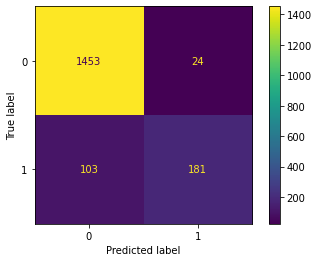

In [104]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_model.classes_)
disp.plot();

По матрице ошибок можно сделать вывод: 

- True Positive (TP) = 177; это означает, что модель предсказала, что 177 пользователей уйдут, и они действительно ушли.

- True Negative (TN) = 1455; модель предсказала, что 1455 пользователей не уйдут и они не действительно не уйдут.

- False Positive (FP) = 22; модель предсказала, что 22 человека уйдут, но они не ушли.

- False Negative (FN) = 107; модель предсказала что 107 пользователей не должно уйти, но на самом деле они ушли.

### Анализ важности признаков

In [105]:
imp_data = pd.DataFrame(best_model.feature_importances_,columns=['res'], 
                                       index=features_test.columns)

In [106]:
imp_data

,res
Type,9.673851
PaperlessBilling,0.584262
PaymentMethod,4.269833
MonthlyCharges,13.750904
TotalDays,63.525359
SeniorCitizen,0.612106
Partner,2.168309
Dependents,1.064228
MultipleLines,4.351146


In [107]:
imp_data = imp_data.sort_values(by='res', ascending = True)

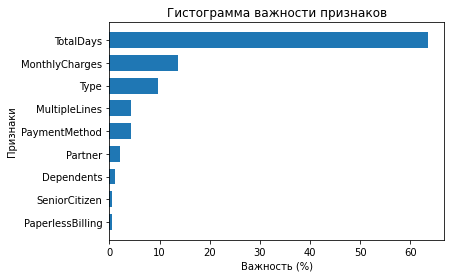

In [108]:
fig = plt.figure()
ax = fig.add_subplot(111)
bars = plt.barh( imp_data.index, imp_data['res'], height=0.7)
ax.set_title('Гистограмма важности признаков')
ax.set_ylabel('Признаки')
ax.set_xlabel('Важность (%)')
plt.show()

По графику можно сделать вывод, что `MonthlyCharges`, `Type` и  `TotalDays` самые важные признаки.

**Вывод**:
- Значения Accuracy: 0.93, ROC-AUC: 0.93 на тестовой выборке;
- По матрице ошибок можно сделать вывод: 
    - True Positive (TP) = 177; это означает, что модель предсказала, что 177 пользователей уйдут, и они действительно ушли.

    - True Negative (TN) = 1455; модель предсказала, что 1455 пользователей не уйдут и они не действительно не уйдут.

    - False Positive (FP) = 22; модель предсказала, что 22 человека уйдут, но они не ушли.

    - False Negative (FN) = 107; модель предсказала что 107 пользователей не должно уйти, но на самом деле они ушли.
- По графику важности признаков, можно сделать вывод что `TotalDays` самый важный признаки.

Вывод по подготовке данных к моделированию, по обучению и проверки модели:
- данные были разделены на обучающую и тестоую выборки в отношении 3:1;
- с использованием Pipeline, Optuna, cross_val_score были обучены три модели (для масштабирования данных использовался StandartScaler, для кодирования данных One Hot Encoder (для LogisticRegression) и Ordinal Encoder (для RandomForestClassifier, CatBoostClassifier):
    - **LogisticRegression;** 
    - **RandomForestClassifier;** 
    - **CatBoostClassifier.**
- была получена лучшая модель CatBoostClassifier;
- для тестовой выборке для лучшей модели было получено Accuracy: 0.0.93, ROC-AUC: 0.93 .
- были проанализированы матрица ошибок и график важности признаков.


## Отчет

**Основные артефакты отчёта**:
1. Ключевые шаги работы над проектом (заказчик не видит план, только отчёт).
2. Анализ соответствия фактической работы запланированным шагам.
3. Рефлексия над сложностями и описание путей их решения.
4. Краткое описание предобработки данных (проблема - что делали).
5. Итоговый список признаков (с расшифровкой) для обучения модели, способы их обработки (каккодировали/стандартизировали/преобразовывали).
6. Сводная таблица исследованных моделей и их метрика на кросс-валидации.
7. Лучшая модель - название, гиперпараметры, метрика на кросс-валидации.
8. Итоговая метрика на test (AUC-ROC и Accuracy).
9. Матрица ошибок (таблица или график + интерпретация).
10. Важность признаков (график + комментарии).

### Ключевые шаги работы над проектом

- Изучить данные, выполнить первичную обработку данных (изменить: названия столбцов, тип данных и т.д)
- Выполнить исследовательский анализ, проверить данные на аномалии. Сделать визуализацию данных: построить графики, диаграммы и т.д.
- Подготовить данные к моделированию: масштабирование, кодировка данных.
- Построить модель машинного обучения, подобрать гиперпараметры. Проанализировать AUC-ROC моделей и выбрать лучшую модель.
- Проверить модель на тестовой выборке и посчитать accuracy. 
- Построить матрицу ошибок и оценить важность признаков.
- Сделать выводы.

### Анализ соответствия фактической работы запланированным шагам

Фактическая работа соответсвует запланированым шагам:
  - данные были загружены и была проведена первичная обпаботка данных;
  - был выполнен исследовательский анализ, данные были проверены на наличие аномалий. Была выполнена визулализация данных, был получен портрет клиента;
  - данные были подготовлены к моделированию: масштабирование числовых признаков и кодировка категориальных признаков;
  - была построена модель машинного обучени и получены лучшие гиперпараметры, далее была выбрана модель с лучшим значением ROC-AUC.
  - полученная модель была проверена на тестовой выборке, и на ней же было получено значение Accuracy.
  - также для модели была получена матрица ошибок, и получена оценка важности признаков.

### Рефлексия над сложностями и описание путей их решения

Изначально в таблице не был сформирован целевой признак. Вследствие чего был сформирован целевой признак `Quit` по значениям столбца `EndDate` следующим образом: если в `EndDate` указано число, значит клиент отказлся от услуг и значение в `Quit` равно 1, если же в `EndDate` не указано число, значит клиент до сих пор пользуется услугами и значение в `Quit` равно 0.

Больше ничего сложностей не вызвало.

### Описание предобработки данных

Предобработка данных заключалась в работе с пропусками в данных, в проверка данных на аномальнось и на мультиколлинеарность:

1. Работа с пропусками в данных. В изначальных таблицах пропусков не было, после объединения таблиц были получены пропуски в следующих столбцах:  `TotalCharges`, `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines`.
    - пропуски в `TotalCharges` образовались поскольку есть клиенты, которые пользуется услугами меньше месяца, заполнили 0.
    - пропуски `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines` заполнили 'NotUsed', поскольку нет информации, что они пользуются этими услугами.

2. Аномалий не было обнаружено.

3. Проверка на мультиколлинеарность. Было получено пороговом значении корреляции 0.8, поэтому были удалены столбцы `InternetService`, `OnlineSecurity`, `OnlineBackup`,`DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`(коррелируют с признаком `MonthlyCharges`). Так же значение корреляции столбца `Gender` с другими столбцами равна нулю, поэтому его тоже удалили.

### Итоговый список признаков для обучения модели, способы их обработки

Категориальные признаки:
- `Type` – тип оплаты: ежемесячный, годовой и тд,
- `PaperlessBilling` – электронный платёжный документ,
- `PaymentMethod` - способ оплаты,
- `SeniorCitizen` - наличие пенсионного статуса по возрасту
- `Partner` - наличие супруга(и),
- `Dependents` - наличие иждивенцев,
- `MultipleLines`  - наличие возможности ведения параллельных линий во время звонка

Числовые признаки:
- `MonthlyCharges` - ежемесячные траты на услуги по договору,
- `TotalDays` - показывает сколько дней человек является пользователем.

Категориальные признаки были закодированы при помощи - OneHotEncoder(для модели логической регрессии)/OrdinalEncoder(для остальных моделей), числовые признаки были масштабированы при помощи - StandardScaler.

### Сводная таблица исследованных моделей и их метрика на кросс-валидации

Было обучено 3 модели:
- модель логической регрессии;
- модель случайного леса;
- модель CatBoost.

In [109]:
models[models.index == 'AUC-ROC']

,Логическая регрессия,Случайный лес,CatBoost
AUC-ROC,0.744625,0.834018,0.916389


### Лучшая модель - название, гиперпараметры, метрика на кросс-валидации.

По значению метрики было получено, что лучшая модель CatBoost с гиперпараметрами {'learning_rate': 0.07703279652911307, 'depth': 4} и значением Accuracy : 0.91

### Итоговая метрика на test (AUC-ROC и Accuracy).

В результате на тестовой выборке были получены следующие значения:

- Accuracy: 0.93

- ROC-AUC: 0.93

Такое значение Accuracy показывает, что доля верных предсказаний составляет 0.925.

### Матрица ошибок (таблица или график + интерпретация).


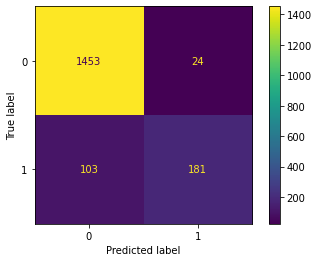

In [110]:
disp.plot();

По матрице ошибок можно сделать вывод: 

- True Positive (TP) = 177; это означает, что модель предсказала, что 176 пользователей уйдут, и они действительно ушли.

- True Negative (TN) = 1455; модель предсказала, что 1455 пользователей не уйдут и они не действительно не уйдут.

- False Positive (FP) = 22; модель предсказала, что 22 человека уйдут, но они не ушли.

- False Negative (FN) = 107; модель предсказала что 108 пользователей не должно уйти, но на самом деле они ушли.


### Важность признаков (график + комментарии).


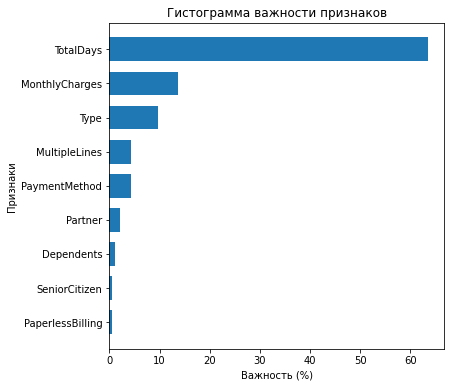

In [111]:
fig, ax = plt.subplots(figsize=(6,6))
bars = plt.barh( imp_data.index, imp_data['res'], height=0.7)
ax.set_title('Гистограмма важности признаков')
ax.set_ylabel('Признаки')
ax.set_xlabel('Важность (%)')
plt.show()

По графику можно сделать вывод, что `MonthlyCharges`, `Type` и  `TotalDays` самые важные признаки.